# Get unique tokens and assign index

In [1]:
#import library
import pandas as pd
import string
import matplotlib.pyplot as plt
import re
import numpy as np

df = pd.read_csv(r"D:\FYP\cyberbullying_preprocessed.csv")

In [2]:
df["text_length"] = df["clean_text"].apply(lambda x: len(x.split()))
df.head()

,tweet_text,cyberbullying_type,hate_speech,clean_text,text_length
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0,"words #katandandre, food crapilicious! #mkr",5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0,#aussietv white? #mkr #theblock #imacelebritya...,11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0,classy whore? red velvet cupcakes?,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0,"meh. p thanks heads up, concerned another angr...",10
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0,isis account pretending kurdish account. like ...,8


In [3]:
# get min length of text
min_length = df['text_length'].min()
print(min_length)

# get max length of text
max_length = df['text_length'].max()
print(max_length)

1
415


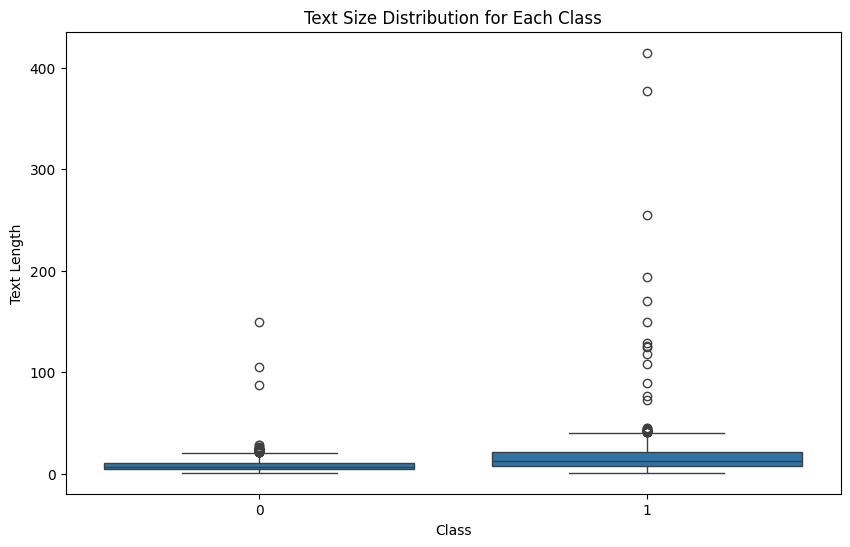

In [4]:
# visualize the size of text for each classes
import seaborn as sns

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='hate_speech', y='text_length', data=df)
plt.title('Text Size Distribution for Each Class')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.show()

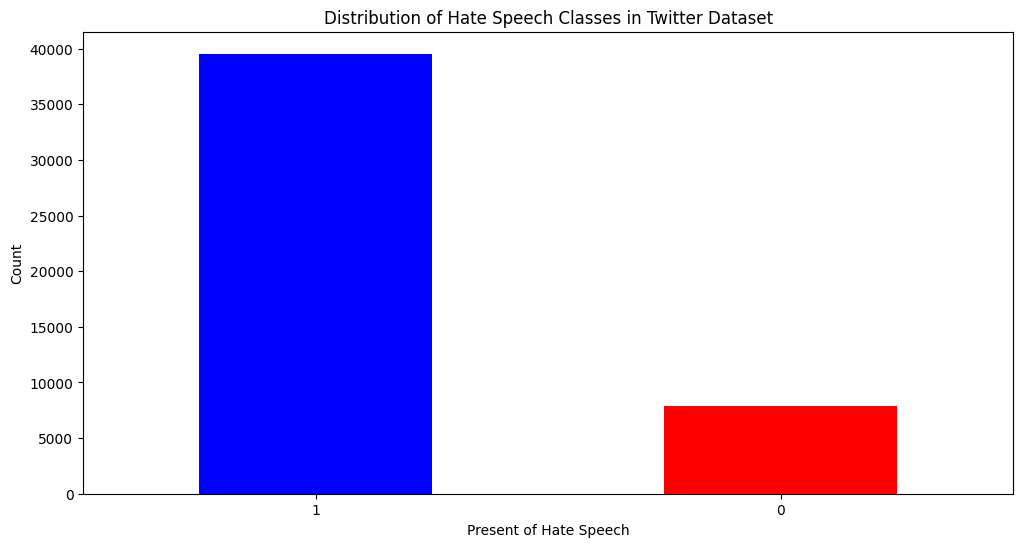

Total number of text that label as non hate = 7847
Total number of text that label as hate = 39538
Total unique value in column 'hate_speech': 
hate_speech
1    39538
0     7847
Name: count, dtype: int64


In [5]:
# visualize dataset
df100 = df[df['text_length'] <= 100].copy()

plt.figure(figsize=(12, 6))
count = df100['hate_speech'].value_counts()
count.plot(kind='bar',color=['blue', 'red'])
plt.title('Distribution of Hate Speech Classes in Twitter Dataset')
plt.xlabel('Present of Hate Speech')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# check and display the total number of occurrences of '0' in 'target'
count_nonhate = df100['hate_speech'].value_counts().get(0, 0)
print(f'Total number of text that label as non hate = {count_nonhate}')

count_hate = df100['hate_speech'].value_counts().get(1, 0)
print(f'Total number of text that label as hate = {count_hate}')

print('Total unique value in column \'hate_speech\': ')
print(df100['hate_speech'].value_counts())

In [ ]:
# initialized BertTokenizer to load pretrained subword tokenizer and define function to perform subword tokenization
import tokenizers
from transformers import AutoTokenizer, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def subword_tokenizer(text):
    tokenized_list = tokenizer.tokenize(text)
    return tokenized_list


print(df100.head())
df100['tokenized_text'] = df100['clean_text'].apply(subword_tokenizer)
print(df100.head())

# Create a list of all tokens in the DataFrame
all_tokens = [token for sublist in df100['tokenized_text'] for token in sublist]

# Create a set of unique tokens
unique_tokens = set(all_tokens)

# Create a vocabulary dictionary with numerical indices
vocab_dict = {token: idx+1 for idx, token in enumerate(unique_tokens)}

# Map the tokenized_text to numerical indices using the vocabulary
df100['numerical_tokens'] = df100['tokenized_text'].apply(lambda tokens: [vocab_dict[token] for token in tokens])

print(df100.head())
print(df100.info())

In [ ]:
print(vocab_dict)

# Create word embedding vectors for each unique word

In [ ]:
# load GloVe model and save in word2vec format
import gensim.downloader as api
from gensim.models import KeyedVectors

glove_path = "D:\Desktop\glove.42B.300d.bin"
word2vec_path = "D:\Desktop\word2vec-google-news-300.bin"

In [ ]:
glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=True)
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
# define embedding size
embedding_size = 300
vocab_size=len(vocab_dict)+1
print(vocab_size)

embedding_matrix_w2v = np.zeros((vocab_size, embedding_size))
embedding_matrix_glove = np.zeros((vocab_size, embedding_size))

# modify embedding matrix is tokens exist in the glove embedding technique
for word, i in vocab_dict.items():
    try:
        # Try to get the vector from GloVe and assign it to the corresponding matrix
        embedding_matrix_glove[i] = glove_model[word]
    except KeyError:
        # If a word is not found in GloVe, set the vector to zeros
        embedding_matrix_glove[i] = np.zeros(embedding_size)
        
    try:
        # Try to get the vector from Word2Vec and assign it to the corresponding matrix
        embedding_matrix_w2v[i] = word2vec_model[word]
    except KeyError:
        # If a word is not found in Word2Vec, set the vector to zeros
        embedding_matrix_w2v[i] = np.zeros(embedding_size)

print(embedding_matrix_glove[1])
print('\n')
print(embedding_matrix_w2v[1])
print('\n')
embedding_matrix = np.concatenate((embedding_matrix_glove, embedding_matrix_w2v), axis=1)
print(embedding_matrix[1])
print(embedding_matrix.shape[1])

In [ ]:
df100["text_length"] = df100["tokenized_text"].apply(lambda x: len(x))

# Drop rows where 'text_length' is 0
df100 = df100[df100['text_length'] != 0]

# Resetting the index after dropping rows
df100 = df100.reset_index(drop=True)

# Now df contains only the rows where 'text_length' is not 0
print(df100.head())

# get max length of text
min_length = df100['text_length'].min()
print(min_length)

# get max length of text
max_length = df100['text_length'].max()
print(max_length)

# Training Preparation

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences


X = df100['numerical_tokens']
y = df100['hate_speech']

# split X and y into train test validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=77)

# instantiate the RandomOverSampler
undersampler = RandomUnderSampler(random_state=66)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train.values.reshape(-1,1), y_train)
X_train = pd.Series(X_train_resampled.flatten())
y_train = pd.Series(y_train_resampled)

# pad the text to have same length
X_train = pad_sequences(X_train,maxlen=max_length, padding='post')
X_val = pad_sequences(X_val,maxlen=max_length, padding='post')
X_test = pad_sequences(X_test,maxlen=max_length, padding='post')
print(X_train[0])

# convert target to array
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')
y_test = np.asarray(y_test).astype('float32')

# printing shape
print('Shape of X train:', X_train.shape)
print('Shape of y train:', y_train.shape)

# printing shape
print('Shape of X val:', X_val.shape)
print('Shape of y val:', y_val.shape)

# printing shape
print('Shape of X test:', X_test.shape)
print('Shape of y test:', y_test.shape)

In [ ]:
# Create a DataFrame to display the class distribution
new_df = pd.DataFrame({'hate_speech': y_train})
class_counts = new_df['hate_speech'].value_counts()

# Plot a bar graph
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar', color='blue')
plt.title('Class Distribution After Downsampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

count_nonhate = new_df['hate_speech'].value_counts().get(0, 0)
print(f'Total number of text that label as non hate = {count_nonhate}')

count_hate = new_df['hate_speech'].value_counts().get(1, 0)
print(f'Total number of text that label as hate = {count_hate}')

print('Total unique value in column \'hate_speech\': ')
print(new_df['hate_speech'].value_counts())

# Deep Learning model without hypertuning

In [14]:
# import libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras import regularizers
from keras.metrics import Precision, Recall, F1Score

In [15]:
import tensorflow as tf
# Define a custom callback to skip the first epoch's results
class EpochNumCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs['epoch_nums'] = epoch+1
        # Only process metrics from the second epoch onwards
        super().on_epoch_end(epoch, logs)
            
callback = [EpochNumCallback(), EarlyStopping(monitor='val_f1_score', patience=3, mode='max', restore_best_weights=True, start_from_epoch=5)]


In [16]:
input_size = X_train.shape[1]

embedding_layer = Embedding(vocab_size, embedding_size*2, weights=[embedding_matrix], trainable=True)

input_layer = Input(shape=(input_size,))
embedding = embedding_layer(input_layer)

conv = Conv1D(32, 10, activation='relu', kernel_regularizer=regularizers.l2(3), padding='same')(embedding)
maxpool = MaxPooling1D(3)(conv)
flatten = Flatten()(maxpool)
dropout = Dropout(0.3)(flatten)
dense = Dense(32)(dropout)
output_layer = Dense(units=1, activation='sigmoid')(dense)

model = Model(input_layer, output_layer)

optimizer = Adam(learning_rate=0.0005)
    
model.compile(optimizer=optimizer, 
            loss='binary_crossentropy', 
            metrics=['accuracy', Precision(thresholds=0.5), Recall(thresholds=0.5), F1Score(threshold=0.5)])

In [17]:
nhp_history = model.fit(X_train, 
          y_train, 
          epochs=30, 
          batch_size=32, 
          validation_data=(X_val, y_val), 
          callbacks=callback)

Epoch 1/30


395/395 [==============================] - 70s 172ms/step - loss: 8.5306 - accuracy: 0.7454 - precision: 0.7991 - recall: 0.6556 - f1_score: 0.7202 - val_loss: 0.5912 - val_accuracy: 0.7590 - val_precision: 0.9849 - val_recall: 0.7232 - val_f1_score: 0.8340 - epoch_nums: 1.0000
Epoch 2/30
395/395 [==============================] - 66s 168ms/step - loss: 0.5644 - accuracy: 0.8186 - precision: 0.8714 - recall: 0.7475 - f1_score: 0.8047 - val_loss: 0.5314 - val_accuracy: 0.8031 - val_precision: 0.9744 - val_recall: 0.7855 - val_f1_score: 0.8698 - epoch_nums: 2.0000
Epoch 3/30
395/395 [==============================] - 60s 153ms/step - loss: 0.5411 - accuracy: 0.8381 - precision: 0.8880 - recall: 0.7738 - f1_score: 0.8270 - val_loss: 0.5264 - val_accuracy: 0.8215 - val_precision: 0.9554 - val_recall: 0.8253 - val_f1_score: 0.8856 - epoch_nums: 3.0000
Epoch 4/30
395/395 [==============================] - 58s 146ms/step - loss: 0.5326 - accuracy: 0.8542 - precision: 0.8981 - rec

149/149 [==============================] - 1s 7ms/step
predicted_accuracy = 0.813212325875897
predicted_precision = 0.9695771219957408
predicted_recall = 0.8023665659617322
predicted_f1_score = 0.8780823804931808


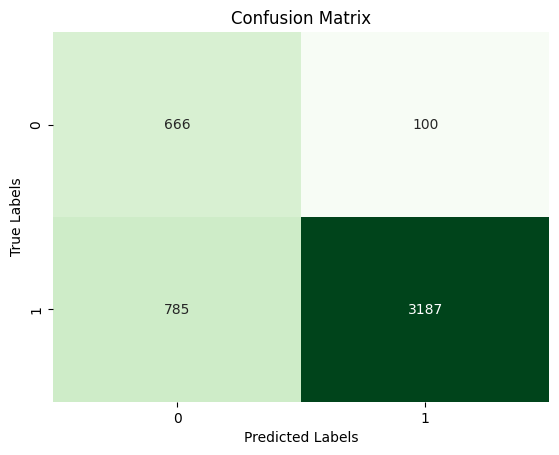

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# predict using trained model with X_test dataset
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype('float32')


# Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'predicted_accuracy = {accuracy}')
# Precision
precision = precision_score(y_test, y_pred_binary)
print(f'predicted_precision = {precision}')
# Recall
recall = recall_score(y_test, y_pred_binary)
print(f'predicted_recall = {recall}')
# F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f'predicted_f1_score = {f1}')

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Deep learnin model hypertuning

In [19]:
from sklearn.utils.class_weight import compute_class_weight

input_size = X_train.shape[1]

def cnn_model(hp):
    conv_filters = hp.Choice("conv_filters", values=[16, 32, 64, 128])
    dense_units = hp.Choice("dense_units", values=[16, 32, 64, 128])
    learning_rate = hp.Choice("learning_rate", values=[0.0001, 0.0005, 0.001, 0.005])
    
    embedding_layer = Embedding(vocab_size, embedding_size*2, weights=[embedding_matrix], trainable=True)

    input_layer = Input(shape=(input_size,))
    embedding = embedding_layer(input_layer)

    conv = Conv1D(conv_filters, 10, activation='relu', kernel_regularizer=regularizers.l2(3), padding='same')(embedding)
    maxpool = MaxPooling1D(3)(conv)
    flatten = Flatten()(maxpool)
    dropout = Dropout(0.3)(flatten)
    dense = Dense(dense_units)(dropout)
    output_layer = Dense(units=1, activation='sigmoid')(dense)

    model = Model(input_layer, output_layer)

    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', Precision(thresholds=0.5), Recall(thresholds=0.5), F1Score(threshold=0.5)])

    return model

In [20]:
# Instantiate the tuner
import keras_tuner as kt
from keras_tuner import Objective
from keras_tuner.tuners import GridSearch

tuner = kt.GridSearch(
    cnn_model,
    objective=Objective('val_f1_score', direction='max'),
    directory='CNN Grid Tuning',
    project_name='Glove+Word2Vec (stack) downsampled grid-tune'
)

Reloading Tuner from CNN Grid Tuning\Glove+Word2Vec (stack) downsampled grid-tune\tuner0.json


In [21]:
# Search for the best hyperparameter configuration
tuner.search(X_train, y_train, 
             batch_size=32, 
             epochs=30, 
             verbose=2, 
             validation_data=(X_val, y_val), 
             callbacks=callback)

# Retrieve best hyperparameters

In [22]:
# Retrieve all trials
all_trials = tuner.oracle.trials.values()

# Loop through each trial and get the score
for trial in all_trials:
    trial_id = trial.trial_id
    trial_score = trial.score
    trial_step = trial.best_step
    print("Trial ID:", trial_id)
    print("Score:", trial_score)
    print("Step:", trial_step)

Trial ID: 0004
Score: 0.8844577670097351
Step: 7
Trial ID: 0008
Score: 0.8840125203132629
Step: 7
Trial ID: 0009
Score: 0.8927474021911621
Step: 7
Trial ID: 0000
Score: 0.8866756558418274
Step: 6
Trial ID: 0002
Score: 0.8915150761604309
Step: 8
Trial ID: 0007
Score: 0.8917315006256104
Step: 3
Trial ID: 0033
Score: 0.885737419128418
Step: 5
Trial ID: 0001
Score: 0.8920978307723999
Step: 8
Trial ID: 0030
Score: 0.9136826395988464
Step: 1
Trial ID: 0028
Score: 0.8866204023361206
Step: 11
Trial ID: 0020
Score: 0.8922122716903687
Step: 15
Trial ID: 0005
Score: 0.8949747681617737
Step: 9
Trial ID: 0017
Score: 0.891120970249176
Step: 6
Trial ID: 0016
Score: 0.9028451442718506
Step: 13
Trial ID: 0003
Score: 0.8847084045410156
Step: 8
Trial ID: 0010
Score: 0.8903999924659729
Step: 7
Trial ID: 0035
Score: 0.8934211134910583
Step: 8
Trial ID: 0034
Score: 0.8850013613700867
Step: 6
Trial ID: 0015
Score: 0.8945712447166443
Step: 1
Trial ID: 0011
Score: 0.8730114698410034
Step: 9
Trial ID: 0032
Scor

In [23]:
# Retrieve the best hyperparameters
best_trial = tuner.oracle.get_trial('0039')
best_hyperparameters = best_trial.hyperparameters

# Re-instantiate the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)
best_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 139)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 139, 600)          11700600  
                                                                 
 conv1d_1 (Conv1D)           (None, 139, 64)           384064    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 46, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2944)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2944)              0         
                                                           

# Train 1D CNNs with best hyperparameters

In [24]:
hp_history = best_model.fit(X_train, 
                         y_train, 
                         epochs=30,
                         batch_size=32, 
                         validation_data=(X_val, y_val), 
                         callbacks=callback)

Epoch 1/30
395/395 [==============================] - 65s 162ms/step - loss: 4.2168 - accuracy: 0.7695 - precision_1: 0.8260 - recall_1: 0.6830 - f1_score: 0.7477 - val_loss: 0.9458 - val_accuracy: 0.8415 - val_precision_1: 0.9067 - val_recall_1: 0.9037 - val_f1_score: 0.9052 - epoch_nums: 1.0000
Epoch 2/30
395/395 [==============================] - 65s 164ms/step - loss: 0.8952 - accuracy: 0.8339 - precision_1: 0.8889 - recall_1: 0.7632 - f1_score: 0.8213 - val_loss: 1.1965 - val_accuracy: 0.8016 - val_precision_1: 0.9758 - val_recall_1: 0.7825 - val_f1_score: 0.8685 - epoch_nums: 2.0000
Epoch 3/30
395/395 [==============================] - 67s 171ms/step - loss: 0.8310 - accuracy: 0.8553 - precision_1: 0.9120 - recall_1: 0.7865 - f1_score: 0.8446 - val_loss: 0.8711 - val_accuracy: 0.8073 - val_precision_1: 0.9690 - val_recall_1: 0.7953 - val_f1_score: 0.8736 - epoch_nums: 3.0000
Epoch 4/30
395/395 [==============================] - 70s 178ms/step - loss: 0.9151 - accuracy: 0.8691 - p

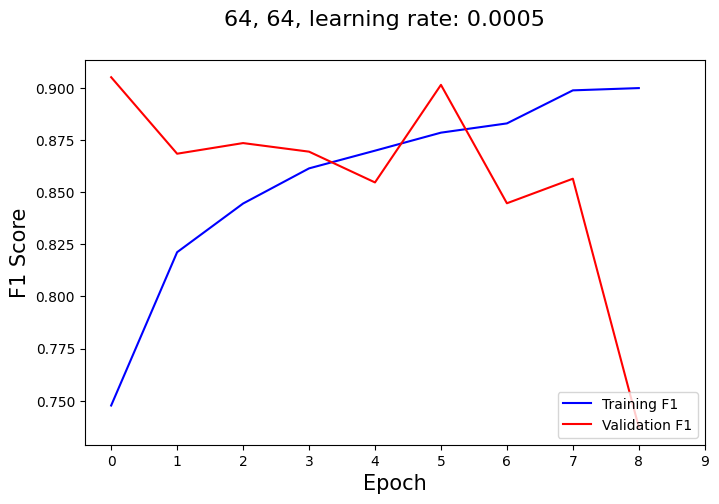

In [25]:
#plotting f1
plt.figure(figsize=(8, 5))  # Create a new figure for each plot
plt.suptitle(f'64, 64, learning rate: 0.0005', fontsize=16)
plt.ylabel('F1 Score', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.plot(hp_history.history['f1_score'], color='b', label='Training F1')
plt.plot(hp_history.history['val_f1_score'], color='r', label='Validation F1')
plt.legend(loc='lower right')

plt.xticks(range(0, len(hp_history.history['f1_score']) + 1, 1))
plt.show()

149/149 [==============================] - 2s 11ms/step
predicted_accuracy = 0.8417053609117772
predicted_precision = 0.9164943123061013
predicted_recall = 0.8924974823766365
predicted_f1_score = 0.9043367346938777


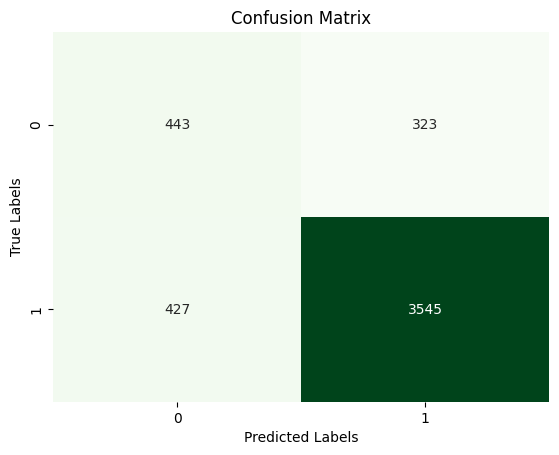

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# predict using trained model with X_test dataset
y_pred1 = best_model.predict(X_test)
y_pred_binary1 = (y_pred1 >= 0.5).astype('float32')


# Accuracy
accuracy1 = accuracy_score(y_test, y_pred_binary1)
print(f'predicted_accuracy = {accuracy1}')
# Precision
precision1 = precision_score(y_test, y_pred_binary1)
print(f'predicted_precision = {precision1}')
# Recall
recall1 = recall_score(y_test, y_pred_binary1)
print(f'predicted_recall = {recall1}')
# F1 Score
f11 = f1_score(y_test, y_pred_binary1)
print(f'predicted_f1_score = {f11}')

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred_binary1)

# plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# predict using trained model with X_test dataset
y_pred2 = model.predict(X_test)
y_pred_binary2 = (y_pred2 > 0.14).astype('float32')


# Accuracy
accuracy2 = accuracy_score(y_test, y_pred_binary2)
print(f'predicted_accuracy = {accuracy2}')
# Precision
precision2 = precision_score(y_test, y_pred_binary2)
print(f'predicted_precision = {precision2}')
# Recall
recall2 = recall_score(y_test, y_pred_binary2)
print(f'predicted_recall = {recall2}')
# F1 Score
f12 = f1_score(y_test, y_pred_binary2)
print(f'predicted_f1_score = {f12}')


# compute confusion matrix
cm = confusion_matrix(y_test, y_pred_binary2)

# plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()